In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
import numpy as np
from scipy import stats
from scipy.stats import kurtosis, skew
import plotly.express as px

# Кейс Kosmos

__id__   bigint    Уникальный id всех записей. Автоинкремент  
__user_id__   int  Уникальный id игрока 

__type__  tinyint 
Тип игры: 
● 1 - Tournament 
●2 - World Tour 
●3 - Training 
●4 - Practice 

__winner__  tinyint 
●1 - победа 
●0 поражение 

__round__ tinyint 
Номер раунда: 
●1 
●2 
●3 

__player_cards__  tinyint  Число карт, которые игрок успел разложить к  концу раунда 

__magic_used__ tinyint     Кол-во магии, которое игрок использовал в раунде 

__hints_used__ smallint    Кол-во подсказок, которое игрок использовал в раунде 

__timestamp__ timestamp    Момент времени, когда закончился раунд 

__length__ mediumint       Длительность раунда в секундах 

## Предобработка данных

In [2]:
kosmos_dataset = pd.read_csv('./files/kosmos_dataset.csv')

In [196]:
kosmos_dataset.describe()

id       user_id          type        winner         round  \
count  3.979488e+06  3.979488e+06  3.979488e+06  3.979488e+06  3.979488e+06   
mean   8.725438e+06  1.109818e+05  1.145261e+00  8.195290e-01  1.856496e+00   
std    1.148779e+06  6.697719e+04  3.840388e-01  3.845793e-01  8.113154e-01   
min    6.735680e+06  1.040000e+02  1.000000e+00  0.000000e+00  0.000000e+00   
25%    7.730566e+06  4.809800e+04  1.000000e+00  1.000000e+00  1.000000e+00   
50%    8.725438e+06  1.119700e+05  1.000000e+00  1.000000e+00  2.000000e+00   
75%    9.720309e+06  1.748320e+05  1.000000e+00  1.000000e+00  3.000000e+00   
max    1.071522e+07  2.063780e+05  4.000000e+00  1.000000e+00  5.000000e+00   

       player_cards    magic_used    hints_used        length  
count  3.979488e+06  3.979488e+06  3.979488e+06  3.979488e+06  
mean   2.994537e+01  1.748682e-01  3.032275e-02  1.371952e+02  
std    2.075844e+01  5.913189e-01  2.183863e-01  5.262704e+01  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%    9.000000e+00  0.000000e+00  0.000000e+00  1.070000e+02  
50%    2.400000e+01  0.000000e+00  0.000000e+00  1.270000e+02  
75%    5.200000e+01  0.000000e+00  0.000000e+00  1.560000e+02  
max    5.200000e+01  4.300000e+01  3.000000e+01  1.410800e+04

In [4]:
%%time
kosmos_dataset['timestamp'] = pd.to_datetime(kosmos_dataset['timestamp'])

Wall time: 3.1 s


In [5]:
events = kosmos_dataset.loc[(kosmos_dataset['timestamp']>pd.Timestamp('2018-11-03'))&
                   (kosmos_dataset['timestamp']<pd.Timestamp('2018-12-04')),:]

In [6]:
events.user_id.nunique()

10947

In [7]:
events['type'].value_counts()

1    3440332
2     507746
3      23906
4       7502
Name: type, dtype: int64

In [8]:
events['month_day'] = [pd.Timestamp(f'2018-{x.month}-{x.day}') for x in events['timestamp']]
events['hour'] = [x.hour for x in events['timestamp']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Понимание трендов

In [9]:
mau = events.user_id.nunique()
mau

10947

In [10]:
dau = events.groupby(['month_day'])['user_id'].nunique().reset_index()

In [11]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=dau.month_day, y=dau.user_id))
fig.show()

In [12]:
group_day_type = events.groupby(['month_day','type']).count()
group_day_type.reset_index(inplace=True)

In [13]:
type_1 = group_day_type.loc[group_day_type['type']==1,:]
type_2 = group_day_type.loc[group_day_type['type']==2,:]
type_3 = group_day_type.loc[group_day_type['type']==3,:]
type_4 = group_day_type.loc[group_day_type['type']==4,:]

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=5, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03
)

fig.add_trace(
    go.Scatter(
        x=dau.month_day,
        y=dau.user_id,
        mode="lines",
        name="DAU"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=type_1["month_day"],
        y=type_1["id"],
        mode="lines",
        name="Tournament"
    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=type_2["month_day"],
        y=type_2["id"],
        mode="lines",
        name="World Tour"
    ),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(
        x=type_3["month_day"],
        y=type_3["id"],
        mode="lines",
        name="Training"
    ),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(
        x=type_4["month_day"],
        y=type_4["id"],
        mode="lines",
        name="Practice"
    ),
    row=5, col=1
)
fig.show()

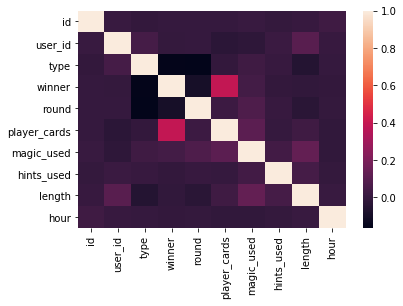

In [15]:
corr = events.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [27]:
events.loc[(events['winner']==1)]['player_cards'].median()

52.0

__Наблюдение__: Прослеживается зависисмость, чем больше выложит карт за игру человек, тем больше вероятноть одержать победу в поединке.

На графиках отчетливо видны всплески активности(количества сыгранных игр). Это может говорить о следюущем:
1. Tournament проходит еженедельно. В конце каждой недели игроки допулучают нехваткающее количество очков. Тем самым возрастает онлайн на выходных.
2. WorldTour проходит раз в две недели.
3. Training и Practice значительно не изменяются.

In [155]:
all_info = pd.DataFrame(columns=['mode_session_time', 'median_duration_r', 
                                'hints_sum', 'hints_median_use','koef_hits_win','pople_use_hits_win',
                                'magic_sum','magic_median_use','koef_magic_win','pople_use_magic_win',
                                 'dau_max','dau_median'
                                ],
                       index=['T1511','T2311', 'T2811',
                              'W1511','W2811'
                             ])

In [156]:
all_info

mode_session_time median_duration_r hints_sum hints_median_use  \
T1511               NaN               NaN       NaN              NaN   
T2311               NaN               NaN       NaN              NaN   
T2811               NaN               NaN       NaN              NaN   
W1511               NaN               NaN       NaN              NaN   
W2811               NaN               NaN       NaN              NaN   

      koef_hits_win pople_use_hits_win magic_sum magic_median_use  \
T1511           NaN                NaN       NaN              NaN   
T2311           NaN                NaN       NaN              NaN   
T2811           NaN                NaN       NaN              NaN   
W1511           NaN                NaN       NaN              NaN   
W2811           NaN                NaN       NaN              NaN   

      koef_magic_win pople_use_magic_win dau_max dau_median  
T1511            NaN                 NaN     NaN        NaN  
T2311            NaN                 NaN     NaN        NaN  
T2811            NaN                 NaN     NaN        NaN  
W1511            NaN                 NaN     NaN        NaN  
W2811            NaN                 NaN     NaN        NaN

## Tournament. 
__Разобьем временные промежутки так, чтобы напоминало нормальное распределение__

Получается так,что локальнык минимумы приходятся на день недели "Среда\Четверг"

### 8.11-15.11.

In [18]:
tournament_15 = events.loc[
    (events.month_day>pd.Timestamp('2018-11-08'))&(events.month_day<pd.Timestamp('2018-11-16'))&
    (events['type']==1)
]

In [19]:
tournament_15.head()

id  user_id  type  winner  round  player_cards  magic_used  \
701815  7437509    29749     1       1      2            25           0   
701816  7437510   101430     1       1      2            52           1   
701817  7437511   201613     1       1      1            52           0   
701824  7437518    49809     1       1      3            52           0   
701825  7437519   165059     1       0      2            11           0   

        hints_used           timestamp  length  month_day  hour  
701815           0 2018-11-09 00:00:01     147 2018-11-09     0  
701816           0 2018-11-09 00:00:04     208 2018-11-09     0  
701817           0 2018-11-09 00:00:05     169 2018-11-09     0  
701824           0 2018-11-09 00:00:06     104 2018-11-09     0  
701825           0 2018-11-09 00:00:07     126 2018-11-09     0

__Пиковое время активности(количество сессий)__

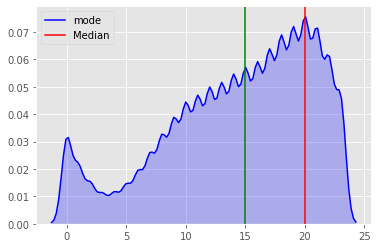

In [201]:
mean = tournament_15.hour.mean()
median = tournament_15.hour.median()
mode_session_time = tournament_15.hour.mode()

sns.kdeplot(tournament_15.hour,color='b', shade=True)
plt.axvline(mode_session_time[0], color='r', linestyle='-')
plt.axvline(median, color='g', linestyle='-')
plt.legend({'mode':mode_session_time,'Median':median})

plt.style.use('ggplot')

Пиковое время приходится на 19:00-21:00

__Средняя продолжительность раунда__

(array([737007., 737008., 737009., 737010., 737011., 737012., 737013.]),
 <a list of 7 Text xticklabel objects>)

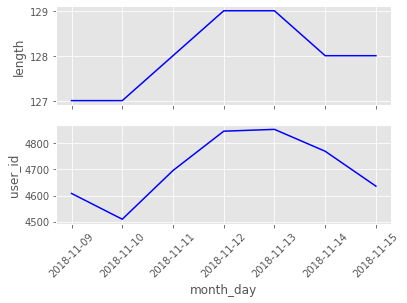

In [243]:
%matplotlib inline
tournament_15_length = tournament_15.groupby('month_day')['length'].median()
tournament_15_user = tournament_15.groupby('month_day')['user_id'].nunique()
median_duration_r = tournament_15['length'].median()


f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(tournament_15_length.index , tournament_15_length,color='b',ax=ax_hist_1)
sns.lineplot(tournament_15_user.index , tournament_15_user,color='b',ax=ax_hist_2)

plt.xticks(rotation=45)

In [256]:
np.corrcoef(tournament_15_length, tournament_15_user)

array([[1.        , 0.92698479],
       [0.92698479, 1.        ]])

Максимальное коллличество сессий было зафиксировано 11.11, однако можно заметить рост медианного времени раунда с даты 12.11 по 13.11. Разберем 11.11,12.11,13.11 детально. 

In [31]:
tournament_15_duration = tournament_15.groupby(['month_day', 'hour'])['length'].median()

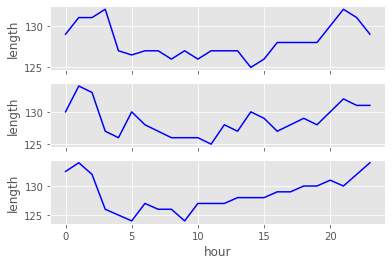

In [32]:
f, (ax_hist_1, ax_hist_2,ax_hist_3) = plt.subplots(3, sharex=True)
sns.lineplot(tournament_15_duration['2018-11-11'].index,tournament_15_duration['2018-11-11'], ax=ax_hist_1, color='b')
sns.lineplot(tournament_15_duration['2018-11-12'].index,tournament_15_duration['2018-11-12'], ax=ax_hist_2, color='b')
sns.lineplot(tournament_15_duration['2018-11-13'].index,tournament_15_duration['2018-11-13'], ax=ax_hist_3, color='b')

Как видно из графиков, в пиковые дни можем заметить рост продолжительности раунда, данный факт говорит об усложнения игры.

## __Количество ключевых действий пользователя за сеанс__

In [33]:
# Всего использовано подсказок
hints_sum = tournament_15.hints_used.sum()
hints_sum

25096

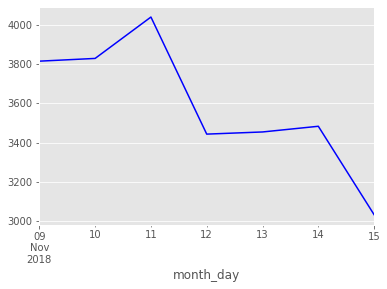

In [34]:
tournament_15.groupby('month_day')['hints_used'].sum().plot(color='b')

In [35]:
# Кто их использует?
all_hints_used_1 = tournament_15.loc[tournament_15['hints_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал игрок подсказку
hints_median_use = all_hints_used_1 // tournament_15.loc[tournament_15['hints_used']==1,:]['user_id'].nunique()
hints_median_use

8

__Помогает ли подсказки победить, % конверсии побед?__

In [36]:
hits_win = tournament_15.loc[(tournament_15['hints_used']==1)&
                             (tournament_15['winner']==1),['user_id']]
hits_lost = tournament_15.loc[(tournament_15['hints_used']==1)&
                             (tournament_15['winner']==0),['user_id']]
count = tournament_15.loc[(tournament_15['hints_used']==1),['user_id']].count()
koef_hits_win_ = ((hits_win.count() - hits_lost.count())/ count)
koef_hits_win_[0]

0.6533791523482245

__Количество карт при победе использую подсказки__

In [280]:
pople_use_hits_win = tournament_15.loc[(tournament_15['hints_used']==1)&(tournament_15['winner']==1)]['player_cards'].median()
pople_use_hits_win

31.0

__В 65% случаем игрок использовавший подсказку побеждал__

In [38]:
# Всего использовано магическую функцию
magic_sum = tournament_15.magic_used.sum()
magic_sum

123577

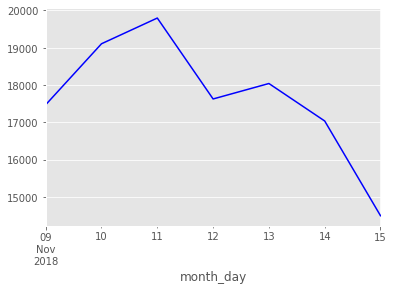

In [39]:
tournament_15.groupby('month_day')['magic_used'].sum().plot( color='b')

In [40]:
# Кто их использует?
all_magic_used_1 = tournament_15.loc[tournament_15['magic_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал магическую функцию
magic_median_use = (all_magic_used_1 // tournament_15.loc[tournament_15['magic_used']==1,:]['user_id'].nunique())
magic_median_use

8

__Помогает ли магическая функция победить, % конверсии побед?__

In [41]:
magic_used_win = tournament_15.loc[(tournament_15['magic_used']==1)&
                             (tournament_15['winner']==1),['user_id']]
magic_used_lost = tournament_15.loc[(tournament_15['magic_used']==1)&
                             (tournament_15['winner']==0),['user_id']]
count = tournament_15.loc[(tournament_15['magic_used']==1),['user_id']].count()
koef_magic_win = (magic_used_win.count() - magic_used_lost.count())/ count
koef_magic_win

user_id    0.760998
dtype: float64

__В 76% случаем игрок использовавший магическую функцию побеждал__

__Вероятность победить используюя и подсказки и магическую функцию__

In [42]:
magic_used_win = tournament_15.loc[(tournament_15['magic_used']==1)&(tournament_15['hints_used']==1)&
                             (tournament_15['winner']==1),['user_id']]

magic_used_lost = tournament_15.loc[(tournament_15['magic_used']==1)&(tournament_15['hints_used']==1)&
                             (tournament_15['winner']==0),['user_id']]
count = tournament_15.loc[(tournament_15['magic_used']==1)&(tournament_15['hints_used']==1),['user_id']].count()
(magic_used_win.count() - magic_used_lost.count())/ count

user_id    0.766485
dtype: float64

__В 76% случаем игрок использовавший подсказку и магическую функцию побеждал__

__Количество кард при победе использую магическую функцию__

In [296]:
pople_use_magic_win = tournament_15.loc[(tournament_15['magic_used']==1)&(tournament_15['winner']==1)]['player_cards'].median()
pople_use_magic_win

52.0

In [95]:
dau_max_1 = tournament_15.groupby('month_day')['user_id'].nunique().values.max()
dau_median_1 = np.median(tournament_15.groupby('month_day')['user_id'].nunique().values)

In [299]:
dau_median_1

4696.0

In [297]:
all_info.loc['T1511',  'mode_session_time'] = mode_session_time[0]
all_info.loc['T1511',  'median_duration_r'] = median_duration_r

all_info.loc['T1511',  'hints_sum'] = hints_sum
all_info.loc['T1511',  'hints_median_use'] = hints_median_use
all_info.loc['T1511',  'koef_hits_win'] = koef_hits_win_[0]
all_info.loc['T1511',  'pople_use_hits_win'] = pople_use_hits_win

all_info.loc['T1511',  'magic_sum'] = magic_sum
all_info.loc['T1511',  'magic_median_use'] = magic_median_use
all_info.loc['T1511',  'koef_magic_win'] = koef_magic_win[0]
all_info.loc['T1511',  'pople_use_magic_win'] = pople_use_magic_win

all_info.loc['T1511',  'dau_max'] = dau_max_1
all_info.loc['T1511',  'dau_median'] = dau_median_1

all_info

mode_session_time median_duration_r hints_sum hints_median_use  \
T1511                20               128     25096                8   
T2311                20               128     27025                8   
T2811                20               128     17000                6   
W1511                20               122      4099                4   
W2811                20               123      2679                3   

      koef_hits_win pople_use_hits_win magic_sum magic_median_use  \
T1511      0.653379                 31    123577                8   
T2311      0.656115                 33    163454               10   
T2811      0.662887                 37    109095                8   
W1511      0.261896               1737     25283                3   
W2811      0.279781               1171     21861                3   

      koef_magic_win pople_use_magic_win dau_max dau_median  
T1511       0.760998                  52    4854       4696  
T2311       0.757519                  52    4837     4777.5  
T2811        0.76919                  52    4895       4760  
W1511       0.555669                6071    1675       1577  
W2811       0.551553                5470    1706       1612

### 15.11-23.11.

In [203]:
tournament_23 = events.loc[
    (events.month_day>pd.Timestamp('2018-11-15'))&(events.month_day<pd.Timestamp('2018-11-24'))&
    (events['type']==1)
]

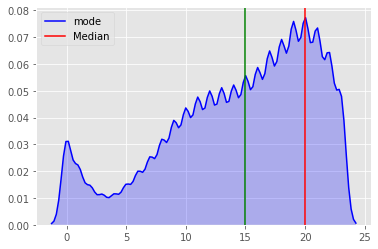

In [204]:
median_2 = tournament_23.hour.median()
mode_session_time_2 = tournament_23.hour.mode()

sns.kdeplot(tournament_23.hour,color='b', shade=True)
plt.axvline(mode_session_time_2[0], color='r', linestyle='-')
plt.axvline(median, color='g', linestyle='-')
plt.legend({'mode':mode_session_time_2,'Median':median_2})

plt.style.use('ggplot')

(array([737014., 737015., 737016., 737017., 737018., 737019., 737020.,
        737021.]), <a list of 8 Text xticklabel objects>)

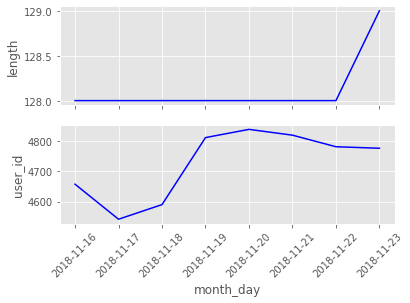

In [244]:
tournament_23_length = tournament_23.groupby('month_day')['length'].median()
tournament_23_user = tournament_23.groupby('month_day')['user_id'].nunique()
median_duration_r_2 = tournament_23['length'].median()


f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(tournament_23_length.index , tournament_23_length,color='b',ax=ax_hist_1)
sns.lineplot(tournament_23_user.index , tournament_23_user,color='b',ax=ax_hist_2)
plt.xticks(rotation=45)


In [257]:
np.corrcoef(tournament_23_length, tournament_23_user)

array([[1.        , 0.17390374],
       [0.17390374, 1.        ]])

Скачек обусловлен сокращеним игроков

In [60]:
# Всего использовано подсказок
hints_sum_2 = tournament_23.hints_used.sum()
hints_sum_2

27025

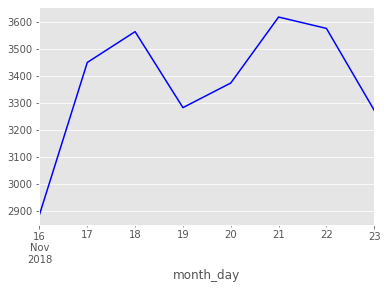

In [61]:
tournament_23.groupby('month_day')['hints_used'].sum().plot(color='b')

In [62]:
# Кто их использует?
all_hints_used_2 = tournament_23.loc[tournament_23['hints_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал игрок подсказку
hints_median_use_2 = all_hints_used_2 // tournament_23.loc[tournament_23['hints_used']==1,:]['user_id'].nunique()
hints_median_use_2

8

In [63]:
hits_win_2 = tournament_23.loc[(tournament_23['hints_used']==1)&
                             (tournament_23['winner']==1),['user_id']]
hits_lost_2 = tournament_23.loc[(tournament_23['hints_used']==1)&
                             (tournament_23['winner']==0),['user_id']]
count_2 = tournament_23.loc[(tournament_23['hints_used']==1),['user_id']].count()
koef_hits_win_2 = ((hits_win_2.count() - hits_lost_2.count())/ count_2)
koef_hits_win_2[0]

0.656115337553865

In [282]:
pople_use_hits_win_2 = tournament_23.loc[(tournament_23['hints_used']==1)&(tournament_23['winner']==1)]['player_cards'].median()
pople_use_hits_win_2


33.0

In [65]:
# Всего использовано магическую функцию
magic_sum_2 = tournament_23.magic_used.sum()
magic_sum_2

163454

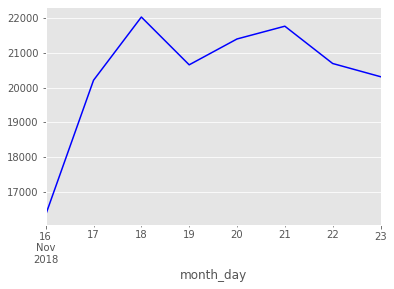

In [67]:
tournament_23.groupby('month_day')['magic_used'].sum().plot( color='b')

In [291]:
# Кто их использует?
all_magic_used_2 = tournament_23.loc[tournament_23['magic_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал магическую функцию
magic_median_use_2 = (all_magic_used_2 // tournament_23.loc[tournament_23['magic_used']==1,:]['user_id'].nunique())
magic_median_use_2

10

In [69]:
magic_used_win_2 = tournament_23.loc[(tournament_23['magic_used']==1)&
                             (tournament_23['winner']==1),['user_id']]
magic_used_lost_2 = tournament_23.loc[(tournament_23['magic_used']==1)&
                             (tournament_23['winner']==0),['user_id']]
count_2 = tournament_23.loc[(tournament_23['magic_used']==1),['user_id']].count()
koef_magic_win_2 = (magic_used_win_2.count() - magic_used_lost_2.count())/ count_2
koef_magic_win_2

user_id    0.757519
dtype: float64

In [292]:
pople_use_magic_win_2 = tournament_23.loc[(tournament_23['magic_used']==1)&(tournament_23['winner']==1)]['player_cards'].median()
pople_use_magic_win_2


52.0

In [97]:
dau_max_2 = tournament_23.groupby('month_day')['user_id'].nunique().values.max()
dau_median_2 = np.median(tournament_23.groupby('month_day')['user_id'].nunique().values)

In [301]:
dau_median_2

4777.5

In [295]:
all_info.loc['T2311',  'mode_session_time'] = mode_session_time_2[0]
all_info.loc['T2311',  'median_duration_r'] = median_duration_r_2

all_info.loc['T2311',  'hints_sum'] = hints_sum_2
all_info.loc['T2311',  'hints_median_use'] = hints_median_use_2
all_info.loc['T2311',  'koef_hits_win'] = koef_hits_win_2[0]
all_info.loc['T2311',  'pople_use_hits_win'] = pople_use_hits_win_2

all_info.loc['T2311',  'magic_sum'] = magic_sum_2
all_info.loc['T2311',  'magic_median_use'] = magic_median_use_2
all_info.loc['T2311',  'koef_magic_win'] = koef_magic_win_2[0]
all_info.loc['T2311',  'pople_use_magic_win'] = pople_use_magic_win_2

all_info.loc['T2311',  'dau_max'] = dau_max_2
all_info.loc['T2311',  'dau_median'] = dau_median_2
all_info

mode_session_time median_duration_r hints_sum hints_median_use  \
T1511                20               128     25096                8   
T2311                20               128     27025                8   
T2811                20               128     17000                6   
W1511                20               122      4099                4   
W2811                20               123      2679                3   

      koef_hits_win pople_use_hits_win magic_sum magic_median_use  \
T1511      0.653379                 31    123577                8   
T2311      0.656115                 33    163454               10   
T2811      0.662887                 37    109095                8   
W1511      0.261896               1737     25283                3   
W2811      0.279781               1171     21861                3   

      koef_magic_win pople_use_magic_win dau_max dau_median  
T1511       0.760998                  52    4854       4696  
T2311       0.757519                  52    4837     4777.5  
T2811        0.76919                  52    4895       4760  
W1511       0.555669                6071    1675       1577  
W2811       0.551553                5470    1706       1612

### 23.11-28.11.

In [221]:
tournament_28 = events.loc[
    (events.month_day>pd.Timestamp('2018-11-23'))&(events.month_day<pd.Timestamp('2018-11-29'))&
    (events['type']==1)
]

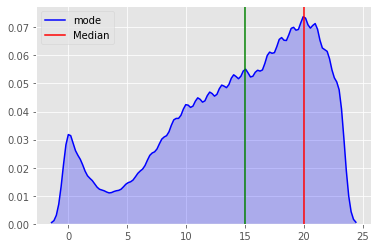

In [222]:
median_3 = tournament_28.hour.median()
mode_session_time_3 = tournament_28.hour.mode()

sns.kdeplot(tournament_28.hour,color='b', shade=True)
plt.axvline(mode_session_time_3[0], color='r', linestyle='-')
plt.axvline(median_3, color='g', linestyle='-')
plt.legend({'mode':mode_session_time_3,'Median':median_3})

plt.style.use('ggplot')

(array([737022. , 737022.5, 737023. , 737023.5, 737024. , 737024.5,
        737025. , 737025.5, 737026. ]), <a list of 9 Text xticklabel objects>)

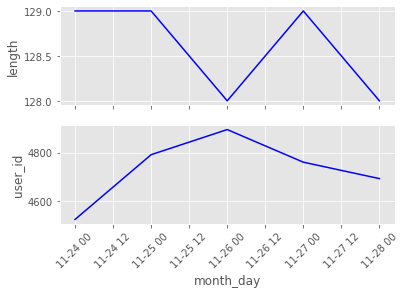

In [251]:
tournament_28_length = tournament_28.groupby('month_day')['length'].median()
tournament_28_user = tournament_28.groupby('month_day')['user_id'].nunique()
median_duration_r_3 = tournament_28['length'].median()

f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(tournament_28_length.index , tournament_28_length,color='b',ax=ax_hist_1)
sns.lineplot(tournament_28_user.index , tournament_28_user,color='b',ax=ax_hist_2)
plt.xticks(rotation=45)




In [258]:
np.corrcoef(tournament_28_length, tournament_28_user)

array([[ 1.       , -0.4056629],
       [-0.4056629,  1.       ]])

In [262]:
ls = [0.92 , 0.17, -0.42]
np.mean(ls)

0.22333333333333338

In [224]:
tournament_28_duration = tournament_28.groupby(['month_day', 'hour'])['length'].median()

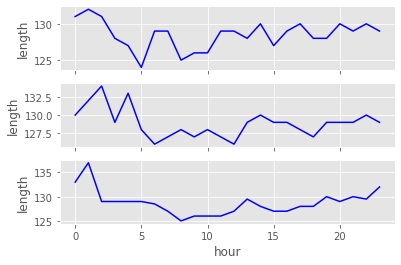

In [225]:
f, (ax_hist_1, ax_hist_2,ax_hist_3) = plt.subplots(3, sharex=True)
sns.lineplot(tournament_28_duration['2018-11-24'].index,tournament_28_duration['2018-11-24'], ax=ax_hist_1, color='b')
sns.lineplot(tournament_28_duration['2018-11-25'].index,tournament_28_duration['2018-11-25'], ax=ax_hist_2, color='b')
sns.lineplot(tournament_28_duration['2018-11-27'].index,tournament_28_duration['2018-11-27'], ax=ax_hist_3, color='b')

In [226]:
# Всего использовано подсказок
hints_sum_3 = tournament_28.hints_used.sum()
hints_sum_3

17000

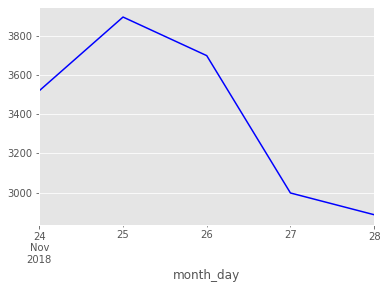

In [227]:
tournament_28.groupby('month_day')['hints_used'].sum().plot(color='b')

In [228]:
# Кто их использует?
all_hints_used_3 = tournament_28.loc[tournament_28['hints_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал игрок подсказку
hints_median_use_3 = all_hints_used_3 // tournament_28.loc[tournament_28['hints_used']==1,:]['user_id'].nunique()
hints_median_use_3

6

In [229]:
hits_win_3 = tournament_28.loc[(tournament_28['hints_used']==1)&
                             (tournament_28['winner']==1),['user_id']]
hits_lost_3 = tournament_28.loc[(tournament_28['hints_used']==1)&
                             (tournament_28['winner']==0),['user_id']]
count_3 = tournament_28.loc[(tournament_28['hints_used']==1),['user_id']].count()
koef_hits_win_3 = ((hits_win_3.count() - hits_lost_3.count())/ count_3)
koef_hits_win_2[0]

0.656115337553865

In [285]:
pople_use_hits_win_3 = tournament_28.loc[(tournament_28['hints_used']==1)&(tournament_28['winner']==1)]['player_cards'].median()
pople_use_hits_win_3

37.0

In [231]:
# Всего использовано магическую функцию
magic_sum_3 = tournament_28.magic_used.sum()
magic_sum_3

109095

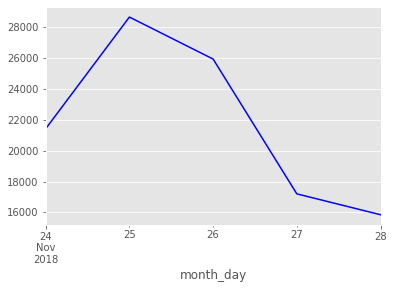

In [232]:
tournament_28.groupby('month_day')['magic_used'].sum().plot( color='b')

In [233]:
# Кто их использует?
all_magic_used_3 = tournament_28.loc[tournament_28['magic_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал магическую функцию
magic_median_use_3 = (all_magic_used_3 // tournament_28.loc[tournament_28['magic_used']==1,:]['user_id'].nunique())
magic_median_use_3

8

In [234]:
magic_used_win_3 = tournament_28.loc[(tournament_28['magic_used']==1)&
                             (tournament_28['winner']==1),['user_id']]
magic_used_lost_3 = tournament_28.loc[(tournament_28['magic_used']==1)&
                             (tournament_28['winner']==0),['user_id']]
count_3 = tournament_28.loc[(tournament_28['magic_used']==1),['user_id']].count()
koef_magic_win_3 = (magic_used_win_3.count() - magic_used_lost_3.count())/ count_3
koef_magic_win_3

user_id    0.76919
dtype: float64

In [293]:
pople_use_magic_win_3 = tournament_28.loc[(tournament_28['magic_used']==1)&(tournament_28['winner']==1)]['player_cards'].median()
pople_use_magic_win_3


52.0

In [236]:
dau_max_3 = tournament_28.groupby('month_day')['user_id'].nunique().values.max()
dau_median_3 = np.median(tournament_28.groupby('month_day')['user_id'].nunique().values)

In [303]:
dau_median_3

4760.0

In [334]:
all_info.loc['T2811',  'mode_session_time'] = mode_session_time_3[0]
all_info.loc['T2811',  'median_duration_r'] = median_duration_r_3

all_info.loc['T2811',  'hints_sum'] = hints_sum_3
all_info.loc['T2811',  'hints_median_use'] = hints_median_use_3
all_info.loc['T2811',  'koef_hits_win'] = koef_hits_win_3[0]
all_info.loc['T2811',  'pople_use_hits_win'] = pople_use_hits_win_3

all_info.loc['T2811',  'magic_sum'] = magic_sum_3
all_info.loc['T2811',  'magic_median_use'] = magic_median_use_3
all_info.loc['T2811',  'koef_magic_win'] = koef_magic_win_3[0]
all_info.loc['T2811',  'pople_use_magic_win'] = pople_use_magic_win_3

all_info.loc['T2811',  'dau_max'] = dau_max_3
all_info.loc['T2811',  'dau_median'] = dau_median_3
all_info

mode_session_time median_duration_r hints_sum hints_median_use  \
T1511                20               128     25096                8   
T2311                20               128     27025                8   
T2811                20               128     17000                6   
W1511                20               122      4099                4   
W2811                20               123      2679                3   

      koef_hits_win pople_use_hits_win magic_sum magic_median_use  \
T1511      0.653379                 31    123577                8   
T2311      0.656115                 33    163454               10   
T2811      0.662887                 37    109095                8   
W1511      0.261896               1737     25283                3   
W2811      0.279781               1171     21861                3   

      koef_magic_win pople_use_magic_win dau_max dau_median  
T1511       0.760998                  52    4854       4696  
T2311       0.757519                  52    4837     4777.5  
T2811        0.76919                  52    4895       4760  
W1511       0.555669                6071    1675       1577  
W2811       0.551553                5470    1706       1612

## WorldTour

### 8.11-15.11.

In [160]:
worldtour_15 = events.loc[
    (events.month_day>pd.Timestamp('2018-11-08'))&(events.month_day<pd.Timestamp('2018-11-16'))&
    (events['type']==2)
]

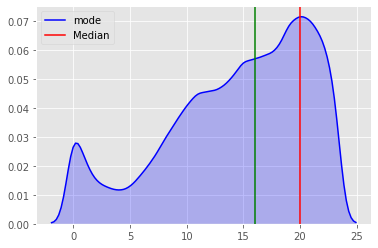

In [304]:
mean_4 = worldtour_15.hour.mean()
median_4 = worldtour_15.hour.median()
mode_session_time_4 = worldtour_15.hour.mode()

sns.kdeplot(worldtour_15.hour,color='b', shade=True)
plt.axvline(mode_session_time_4[0], color='r', linestyle='-')
plt.axvline(median_4, color='g', linestyle='-')
plt.legend({'mode':mode_session_time_4,'Median':median_4})

plt.style.use('ggplot')

(array([737007., 737008., 737009., 737010., 737011., 737012., 737013.]),
 <a list of 7 Text xticklabel objects>)

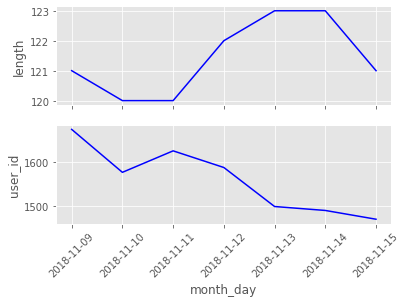

In [306]:
worldtour_15_length = worldtour_15.groupby('month_day')['length'].median()
worldtour_15_user = worldtour_15.groupby('month_day')['user_id'].nunique()
median_duration_r_4 = worldtour_15['length'].median()

f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(worldtour_15_length.index , worldtour_15_length,color='b',ax=ax_hist_1)
sns.lineplot(worldtour_15_user.index , worldtour_15_user,color='b',ax=ax_hist_2)
plt.xticks(rotation=45)



In [308]:
np.corrcoef(worldtour_15_length,worldtour_15_user)

array([[ 1.        , -0.54444422],
       [-0.54444422,  1.        ]])

In [163]:
worldtour_15_duration = worldtour_15.groupby(['month_day', 'hour'])['length'].median()

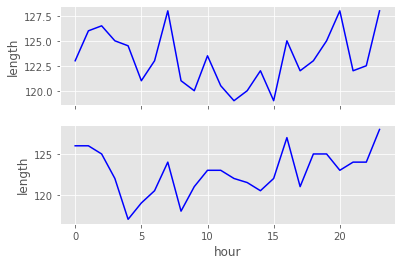

In [165]:
f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(worldtour_15_duration['2018-11-13'].index,worldtour_15_duration['2018-11-13'], ax=ax_hist_1, color='b')
sns.lineplot(worldtour_15_duration['2018-11-14'].index,worldtour_15_duration['2018-11-14'], ax=ax_hist_2, color='b')

In [166]:
# Всего использовано подсказок
hints_sum_4 = worldtour_15.hints_used.sum()
hints_sum_4

4099

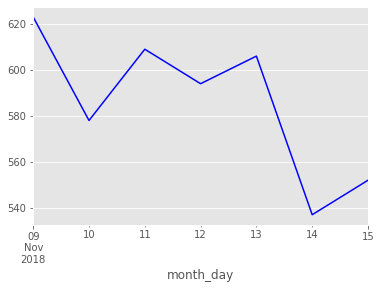

In [167]:
worldtour_15.groupby('month_day')['hints_used'].sum().plot(color='b')

In [168]:
# Кто их использует?
all_hints_used_4 = worldtour_15.loc[worldtour_15['hints_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал игрок подсказку
hints_median_use_4 = all_hints_used_4 // worldtour_15.loc[worldtour_15['hints_used']==1,:]['user_id'].nunique()
hints_median_use_4

4

In [170]:
hits_win_4 = worldtour_15.loc[(worldtour_15['hints_used']==1)&
                             (worldtour_15['winner']==1),['user_id']]
hits_lost_4 = worldtour_15.loc[(worldtour_15['hints_used']==1)&
                             (worldtour_15['winner']==0),['user_id']]
count_4 = worldtour_15.loc[(worldtour_15['hints_used']==1),['user_id']].count()
koef_hits_win_4 = ((hits_win_4.count() - hits_lost_4.count())/ count_4)
koef_hits_win_4[0]

0.26189611333091173

In [326]:
pople_use_hits_win_4 = worldtour_15.loc[(worldtour_15['hints_used']==1)&(worldtour_15['winner']==1)]['player_cards'].median()
pople_use_hits_win_4




52.0

In [172]:
# Всего использовано магическую функцию
magic_sum_4 = worldtour_15.magic_used.sum()
magic_sum_4

25283

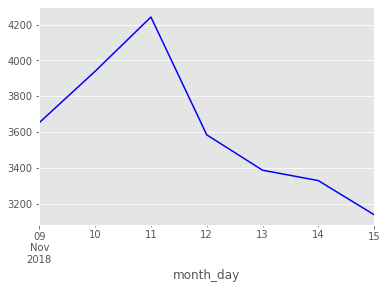

In [173]:
worldtour_15.groupby('month_day')['magic_used'].sum().plot( color='b')

In [174]:
# Кто их использует?
all_magic_used_4 = worldtour_15.loc[worldtour_15['magic_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал магическую функцию
magic_median_use_4 = (all_magic_used_4 // worldtour_15.loc[worldtour_15['magic_used']==1,:]['user_id'].nunique())
magic_median_use_4

3

In [175]:
magic_used_win_4 = worldtour_15.loc[(worldtour_15['magic_used']==1)&
                             (worldtour_15['winner']==1),['user_id']]
magic_used_lost_4 = worldtour_15.loc[(worldtour_15['magic_used']==1)&
                             (worldtour_15['winner']==0),['user_id']]
count_4 = worldtour_15.loc[(worldtour_15['magic_used']==1),['user_id']].count()
koef_magic_win_4 = (magic_used_win_4.count() - magic_used_lost_4.count())/ count_4
koef_magic_win_4

user_id    0.555669
dtype: float64

In [327]:
pople_use_magic_win_4 = worldtour_15.loc[(worldtour_15['magic_used']==1)&(worldtour_15['winner']==1)]['player_cards'].median()
pople_use_magic_win_4



52.0

In [177]:
dau_max_4 = worldtour_15.groupby('month_day')['user_id'].nunique().values.max()
dau_median_4 = np.median(worldtour_15.groupby('month_day')['user_id'].nunique().values)

In [329]:
dau_median_4

1577.0

In [335]:
all_info.loc['W1511',  'mode_session_time'] = mode_session_time_4[0]
all_info.loc['W1511',  'median_duration_r'] = median_duration_r_4

all_info.loc['W1511',  'hints_sum'] = hints_sum_4
all_info.loc['W1511',  'hints_median_use'] = hints_median_use_4
all_info.loc['W1511',  'koef_hits_win'] = koef_hits_win_4[0]
all_info.loc['W1511',  'pople_use_hits_win'] = pople_use_hits_win_4

all_info.loc['W1511',  'magic_sum'] = magic_sum_4
all_info.loc['W1511',  'magic_median_use'] = magic_median_use_4
all_info.loc['W1511',  'koef_magic_win'] = koef_magic_win_4[0]
all_info.loc['W1511',  'pople_use_magic_win'] = pople_use_magic_win_4

all_info.loc['W1511',  'dau_max'] = dau_max_4
all_info.loc['W1511',  'dau_median'] = dau_median_4
all_info

mode_session_time median_duration_r hints_sum hints_median_use  \
T1511                20               128     25096                8   
T2311                20               128     27025                8   
T2811                20               128     17000                6   
W1511                20               122      4099                4   
W2811                20               123      2679                3   

      koef_hits_win pople_use_hits_win magic_sum magic_median_use  \
T1511      0.653379                 31    123577                8   
T2311      0.656115                 33    163454               10   
T2811      0.662887                 37    109095                8   
W1511      0.261896                 52     25283                3   
W2811      0.279781               1171     21861                3   

      koef_magic_win pople_use_magic_win dau_max dau_median  
T1511       0.760998                  52    4854       4696  
T2311       0.757519                  52    4837     4777.5  
T2811        0.76919                  52    4895       4760  
W1511       0.555669                  52    1675       1577  
W2811       0.551553                5470    1706       1612

### 23.11-28.11.

In [179]:
worldtour_28 = events.loc[
    (events.month_day>pd.Timestamp('2018-11-23'))&(events.month_day<pd.Timestamp('2018-11-29'))&
    (events['type']==2)
]

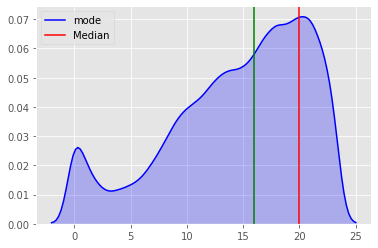

In [180]:
median_5 = worldtour_28.hour.median()
mode_session_time_5 = worldtour_28.hour.mode()

sns.kdeplot(worldtour_28.hour,color='b', shade=True)
plt.axvline(mode_session_time_5[0], color='r', linestyle='-')
plt.axvline(median_5, color='g', linestyle='-')
plt.legend({'mode':mode_session_time_5,'Median':median_5})

plt.style.use('ggplot')

(array([737022. , 737022.5, 737023. , 737023.5, 737024. , 737024.5,
        737025. , 737025.5, 737026. ]), <a list of 9 Text xticklabel objects>)

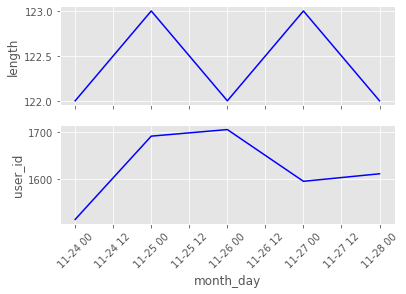

In [311]:
worldtour_28_length = worldtour_28.groupby('month_day')['length'].median()
worldtour_28_user = worldtour_28.groupby('month_day')['user_id'].nunique()
median_duration_r_5 = worldtour_28['length'].median()


f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(worldtour_28_length.index , worldtour_28_length,color='b',ax=ax_hist_1)
sns.lineplot(worldtour_28_user.index , worldtour_28_user,color='b',ax=ax_hist_2)
plt.xticks(rotation=45)


In [312]:
np.corrcoef(worldtour_28_length,worldtour_28_user)

array([[1.        , 0.23258669],
       [0.23258669, 1.        ]])

In [182]:
worldtour_28_duration = worldtour_28.groupby(['month_day', 'hour'])['length'].median()

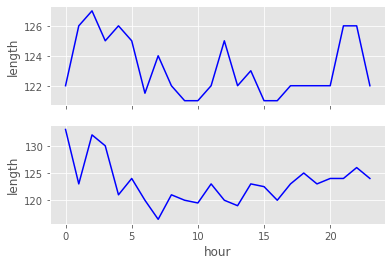

In [183]:
f, (ax_hist_1, ax_hist_2) = plt.subplots(2, sharex=True)
sns.lineplot(worldtour_28_duration['2018-11-25'].index,worldtour_28_duration['2018-11-25'], ax=ax_hist_1, color='b')
sns.lineplot(worldtour_28_duration['2018-11-27'].index,worldtour_28_duration['2018-11-27'], ax=ax_hist_2, color='b')

In [184]:
# Всего использовано подсказок
hints_sum_5 = worldtour_28.hints_used.sum()
hints_sum_5

2679

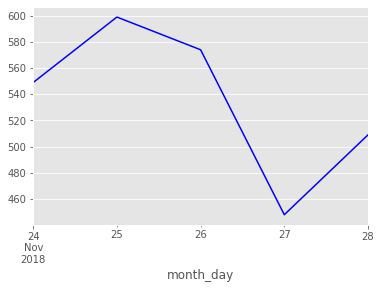

In [185]:
worldtour_28.groupby('month_day')['hints_used'].sum().plot(color='b')

In [186]:
# Кто их использует?
all_hints_used_5 = worldtour_28.loc[worldtour_28['hints_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал игрок подсказку
hints_median_use_5 = all_hints_used_5 // worldtour_28.loc[worldtour_28['hints_used']==1,:]['user_id'].nunique()
hints_median_use_5

3

In [187]:
hits_win_5 = worldtour_28.loc[(worldtour_28['hints_used']==1)&
                             (worldtour_28['winner']==1),['user_id']]
hits_lost_5 = worldtour_28.loc[(worldtour_28['hints_used']==1)&
                             (worldtour_28['winner']==0),['user_id']]
count_5 = worldtour_28.loc[(worldtour_28['hints_used']==1),['user_id']].count()
koef_hits_win_5 = ((hits_win_5.count() - hits_lost_5.count())/ count_5)
koef_hits_win_5[0]

0.2797814207650273

In [330]:
pople_use_hits_win_5 = worldtour_28.loc[(worldtour_28['hints_used']==1)&(worldtour_28['winner']==1)]['player_cards'].median()
pople_use_hits_win_5



52.0

In [189]:
# Всего использовано магическую функцию
magic_sum_5 = worldtour_28.magic_used.sum()
magic_sum_5

21861

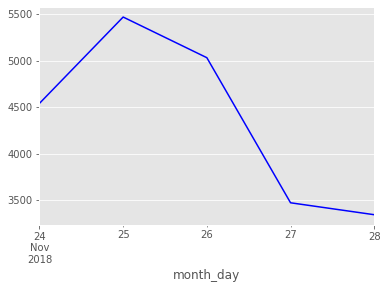

In [190]:
worldtour_28.groupby('month_day')['magic_used'].sum().plot( color='b')

In [191]:
# Кто их использует?
all_magic_used_5 = worldtour_28.loc[worldtour_28['magic_used']==1,:]['user_id'].count()
# Среднее количество раз, сколько раз использовал магическую функцию
magic_median_use_5 = (all_magic_used_5 // worldtour_28.loc[worldtour_28['magic_used']==1,:]['user_id'].nunique())
magic_median_use_5

3

In [192]:
magic_used_win_5 = worldtour_28.loc[(worldtour_28['magic_used']==1)&
                             (worldtour_28['winner']==1),['user_id']]
magic_used_lost_5 = worldtour_28.loc[(worldtour_28['magic_used']==1)&
                             (worldtour_28['winner']==0),['user_id']]
count_5 = worldtour_28.loc[(worldtour_28['magic_used']==1),['user_id']].count()
koef_magic_win_5 = (magic_used_win_5.count() - magic_used_lost_5.count())/ count_5
koef_magic_win_5

user_id    0.551553
dtype: float64

In [331]:
pople_use_magic_win_5 = worldtour_28.loc[(worldtour_28['magic_used']==1)&(worldtour_28['winner']==1)]['player_cards'].median()
pople_use_magic_win_5



52.0

In [194]:
dau_max_5 = worldtour_28.groupby('month_day')['user_id'].nunique().values.max()
dau_median_5 = np.median(worldtour_28.groupby('month_day')['user_id'].nunique().values)

In [333]:
dau_median_5

1612.0

In [336]:
all_info.loc['W2811',  'mode_session_time'] = mode_session_time_5[0]
all_info.loc['W2811',  'median_duration_r'] = median_duration_r_5

all_info.loc['W2811',  'hints_sum'] = hints_sum_5
all_info.loc['W2811',  'hints_median_use'] = hints_median_use_5
all_info.loc['W2811',  'koef_hits_win'] = koef_hits_win_5[0]
all_info.loc['W2811',  'pople_use_hits_win'] = pople_use_hits_win_5

all_info.loc['W2811',  'magic_sum'] = magic_sum_5
all_info.loc['W2811',  'magic_median_use'] = magic_median_use_5
all_info.loc['W2811',  'koef_magic_win'] = koef_magic_win_5[0]
all_info.loc['W2811',  'pople_use_magic_win'] = pople_use_magic_win_5

all_info.loc['W2811',  'dau_max'] = dau_max_5
all_info.loc['W2811',  'dau_median'] = dau_median_5
all_info

mode_session_time median_duration_r hints_sum hints_median_use  \
T1511                20               128     25096                8   
T2311                20               128     27025                8   
T2811                20               128     17000                6   
W1511                20               122      4099                4   
W2811                20               123      2679                3   

      koef_hits_win pople_use_hits_win magic_sum magic_median_use  \
T1511      0.653379                 31    123577                8   
T2311      0.656115                 33    163454               10   
T2811      0.662887                 37    109095                8   
W1511      0.261896                 52     25283                3   
W2811      0.279781                 52     21861                3   

      koef_magic_win pople_use_magic_win dau_max dau_median  
T1511       0.760998                  52    4854       4696  
T2311       0.757519                  52    4837     4777.5  
T2811        0.76919                  52    4895       4760  
W1511       0.555669                  52    1675       1577  
W2811       0.551553                  52    1706       1612

In [ ]:
events_hyp_1 = events.groupby('month_day')['length'].median()
events_hyp_1_1 = events.groupby('month_day')['user_id'].nunique()

In [322]:
events_2 = events.loc[events['type']==2,:]
events_hyp_1 = events_2.groupby('month_day').median()
events_hyp_1_1 = events_2.groupby('month_day').nunique()

In [323]:
events_hyp_1 = events_hyp_1.loc[:,['length']]
events_hyp_1['user_id'] = events_hyp_1_1.loc[:,['user_id']]

In [324]:
import scipy
scipy.stats.wilcoxon(events_hyp_1.length,events_hyp_1.user_id)

WilcoxonResult(statistic=0.0, pvalue=1.1741945398998534e-06)

In [325]:
1.1741945398998534 == 1.1741945398998534

True